In [1]:
import numpy as np
from sklearn.preprocessing import PolynomialFeatures

"""
    Linear regression using the Ridge method
"""

def RidgeRegression(x, y, z, degree=5, l=0.0001):
    """
    :param x: numpy vector of size (n, 1)
    :param y: numpy vector of size (n, 1)
    :param degree: degree of polynomial fit
    :param l: Ridge penalty coefficient
    :return: numpy array with the beta coefficients
    """
    # Calculate matrix with x, y - polynomials
    M_ = np.c_[x, y]
    poly = PolynomialFeatures(degree)
    M = poly.fit_transform(M_)



    # Calculate beta
    A = np.arange(1, degree + 2)
    rows = np.sum(A)
    beta = (np.linalg.inv(M.T.dot(M) + l * np.identity(rows))).dot(M.T).dot(z)

    return beta


In [2]:
"""
Functions to use in analysis of a regression method
"""
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

def FrankeFunction(x,y, noise=0.01):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return (term1 + term2 + term3 + term4 + noise*np.random.randn(len(x)))

def R2(zReal, zPredicted):
    """
    :param zReal: actual z-values, size (n, 1)
    :param zPredicted: predicted z-values, size (n, 1)
    :return: R2-score
    """
    meanValue = np.mean(zReal)
    numerator = np.sum((zReal - zPredicted)**2)
    denominator = np.sum((zReal - meanValue)**2)
    result = 1 - (numerator/denominator)
    return result

def MeanSquaredError(z, z_hat):
    """
    :param z: actual z-values, size (n, 1)
    :param z_hat: predicted z-values, size (n, 1)
    :return: Mean squared error
    """
    MSE = np.sum((z - z_hat)**2)/len(z)
    return MSE

def betaConfidenceInterval_Ridge(z_real, beta, X, l):
    """
    Compute a 90% confidence interval for the beta coefficients - Ridge
    """

    # Calculate variance squared in the error
    z_hat = X.dot(beta)
    N, P = np.shape(X)
    sigma_2 = (np.sum(np.power((z_real-z_hat), 2)))/N

    # Calculate the variance squared of the beta coefficients
    XTX= X.T.dot(X)
    R, R = np.shape(XTX)
    var_beta = np.diag(sigma_2*np.linalg.inv((XTX + l*np.identity(R))))

    # The square root of var_beta is the standard error. Use it to calculate confidence intervals
    i_minus = beta - 1.645*np.sqrt(var_beta/N)
    i_plus = beta + 1.645*np.sqrt(var_beta/N)

    return i_minus, i_plus

def betaConfidenceInterval_OLS(z_real, beta, X):
    """
    Compute a 90% confidence interval for the beta coefficients
    """

    # Calculate variance squared in the error
    z_hat = X.dot(beta)
    N, P = np.shape(X)
    sigma_2 = (np.sum(np.power((z_real-z_hat), 2)))/N

    # Calculate the variance squared of the beta coefficients
    var_beta = np.diag(sigma_2*np.linalg.inv((X.T.dot(X))))

    # The square root of var_beta is the standard error. Use it to calculate confidence intervals
    i_minus = beta - 1.645*np.sqrt(var_beta/N)
    i_plus = beta + 1.645*np.sqrt(var_beta/N)

    return i_minus, i_plus

def plotFrankes(beta, degree=5):
    """
    Plot Franke's function
    """

    x = np.arange(0, 1, 0.01)
    y = np.arange(0, 1, 0.01)

    x_, y_ = np.meshgrid(x, y)
    x = x_.reshape(-1,1)
    y = y_.reshape(-1,1)

    M = np.c_[x, y]
    poly = PolynomialFeatures(degree=degree)
    M_ = poly.fit_transform(M)
    predict = M_.dot(beta)

    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot_surface(x_, y_, predict.reshape(100, 100), cmap=cm.coolwarm, linewidth=0, antialiased=False)
    plt.show()

In [14]:
from sklearn.utils import resample
def bootstrap(x, y, z, p_degree, method, n_bootstrap=100):
    # Randomly shuffle data
    data_set = np.c_[x, y, z]
    np.random.shuffle(data_set)
    set_size = round(len(x)/5)

    # Extract test-set, never used in training. About 1/5 of total data
    x_test = data_set[0:set_size, 0]
    y_test = data_set[0:set_size, 1]
    z_test = data_set[0:set_size, 2]
    test_indices = np.linspace(0, set_size-1, set_size)

    # And define the training set as the rest of the data
    x_train = np.delete(data_set[:, 0], test_indices)
    y_train = np.delete(data_set[:, 1], test_indices)
    z_train = np.delete(data_set[:, 2], test_indices)

    Z_predict = []

    MSE = []
    R2s = []
    for i in range(n_bootstrap):
        x_, y_, z_ = resample(x_train, y_train, z_train)

        if method == 'Ridge':
            # Ridge regression, save beta values
            beta = RidgeRegression(x_, y_, z_, degree=p_degree)
        elif method == 'Lasso':
            beta = Lasso(x_, y_, z_, degree=p_degree)
        elif method == 'OLS':
            beta = ols(x_, y_, z_, degree=p_degree)
        else:
            print('ERROR: Cannot recognize method')
            return 0

        M_ = np.c_[x_test, y_test]
        poly = PolynomialFeatures(p_degree)
        M = poly.fit_transform(M_)
        z_hat = M.dot(beta)

        Z_predict.append(z_hat)

        # Calculate MSE
        MSE.append(np.mean((z_test - z_hat)**2))
        R2s.append(R2(z_test, z_hat))
        print('Round: ', i)

    # Calculate MSE, Bias and Variance
    MSE_M = np.mean(MSE)
    R2_M = np.mean(R2s)
    bias = np.mean((z_test - np.mean(Z_predict, axis=0, keepdims=True))**2)
    variance = np.mean(np.var(Z_predict, axis=0, keepdims=True))
    return MSE_M, R2_M, bias, variance

In [5]:
from sklearn.preprocessing import PolynomialFeatures
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D


In [6]:
"""
Analysis of a Ridge Regression model of Franke's function, using set of 1000 random x and y points
"""
# Load random data, 1000 points
X = np.load('data.npy')
x = X[:, 0]
y = X[:, 1]

# Calculate Franke's function without noise
z = FrankeFunction(x, y, noise=0)

In [7]:
# Study dependence on lambdas
lambdas = [10**-7, 10**-6, 10**-5, 10**-4, 10**-3, 10**-2, 10**-1, 1]
lambdas_log = [-7, -6, -5, -4, -3, -2, -1, 0]

print('\nINVESTIGATE LAMBDAS')
Bs = []
for la in lambdas:
    Bs.append(RidgeRegression(x, y, z, l=la))

# Generate test data
x_test = np.random.rand(200)
y_test = np.random.rand(200)
z_test = FrankeFunction(x_test, y_test, noise=0)

# Calculate MSE, R2scores
M_ = np.c_[x_test, y_test]
poly5 = PolynomialFeatures(5)
M = poly5.fit_transform(M_)

MSEs = []
R2s = []
for i in range(len(lambdas)):
    z_predict = M.dot(Bs[i])
    MSE = MeanSquaredError(z_test, z_predict)
    MSEs.append(MSE)
    R2_score = R2(z_test, z_predict)
    R2s.append(R2_score)
    print('--- Lambda value: {0} ---\n Mean Squared error: {1:.7f} \n R2 Score: {2:.7f}\n'.format(lambdas[i], MSE, R2_score))


INVESTIGATE LAMBDAS
--- Lambda value: 1e-07 ---
 Mean Squared error: 0.0018027 
 R2 Score: 0.9776452

--- Lambda value: 1e-06 ---
 Mean Squared error: 0.0018011 
 R2 Score: 0.9776643

--- Lambda value: 1e-05 ---
 Mean Squared error: 0.0018164 
 R2 Score: 0.9774747

--- Lambda value: 0.0001 ---
 Mean Squared error: 0.0025059 
 R2 Score: 0.9689243

--- Lambda value: 0.001 ---
 Mean Squared error: 0.0041733 
 R2 Score: 0.9482478

--- Lambda value: 0.01 ---
 Mean Squared error: 0.0054733 
 R2 Score: 0.9321263

--- Lambda value: 0.1 ---
 Mean Squared error: 0.0082985 
 R2 Score: 0.8970911

--- Lambda value: 1 ---
 Mean Squared error: 0.0122727 
 R2 Score: 0.8478069



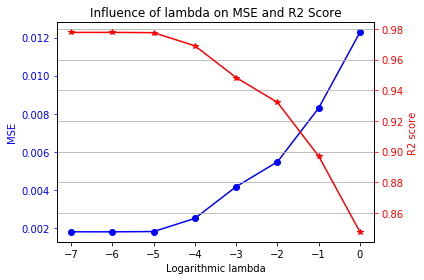

In [8]:
# Make figure
fig, ax1 = plt.subplots()
ax1.plot(lambdas_log, MSEs, 'bo-')
ax1.set_xlabel('Logarithmic lambda')
ax1.set_ylabel('MSE', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.plot(lambdas_log, R2s, 'r*-')
ax2.set_ylabel('R2 score', color='r')
ax2.tick_params('y', colors='r')

plt.grid(True)
plt.title('Influence of lambda on MSE and R2 Score')
fig.tight_layout()
plt.show()

--- lambda value: 1e-05 --
 Noise: 0.001 
 Mean Squared error: 0.0019067 
 R2 Score: 0.9785861

 Noise: 0.006 
 Mean Squared error: 0.0019938 
 R2 Score: 0.9776701

 Noise: 0.011 
 Mean Squared error: 0.0020793 
 R2 Score: 0.9765812

 Noise: 0.016 
 Mean Squared error: 0.0023470 
 R2 Score: 0.9737389

 Noise: 0.021 
 Mean Squared error: 0.0023469 
 R2 Score: 0.9737976

 Noise: 0.026000000000000002 
 Mean Squared error: 0.0024422 
 R2 Score: 0.9728667

 Noise: 0.031 
 Mean Squared error: 0.0028947 
 R2 Score: 0.9666580

 Noise: 0.036000000000000004 
 Mean Squared error: 0.0031439 
 R2 Score: 0.9652932

 Noise: 0.041 
 Mean Squared error: 0.0032652 
 R2 Score: 0.9637618

 Noise: 0.046 
 Mean Squared error: 0.0038947 
 R2 Score: 0.9580313

 Noise: 0.051000000000000004 
 Mean Squared error: 0.0051154 
 R2 Score: 0.9440888

 Noise: 0.056 
 Mean Squared error: 0.0054919 
 R2 Score: 0.9395374

 Noise: 0.061 
 Mean Squared error: 0.0064550 
 R2 Score: 0.9327813

 Noise: 0.066 
 Mean Squared er

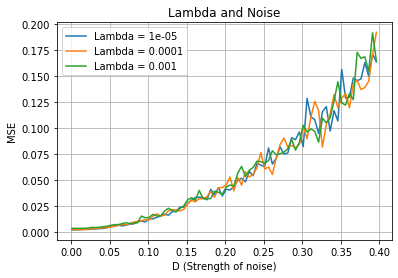

In [9]:
# consider how the strength of noise affects the lambda values
noise = np.arange(0.001, 0.4, 0.005)
lambdas = [10**-5, 10**-4, 10**-3]
Bs = []

# Generate more data to test
x_test = np.random.rand(200)
y_test = np.random.rand(200)
M_ = np.c_[x_test, y_test]
poly5 = PolynomialFeatures(5)
M = poly5.fit_transform(M_)

for la in lambdas:
    B = []
    for n in noise:
        z = FrankeFunction(x, y, noise=n)
        B.append(RidgeRegression(x, y, z, l=la))
    Bs.append(B)

lines = []
plt.figure()
for i in range(len(lambdas)):
    print('--- lambda value:', lambdas[i], '--')
    line = []
    for j in range(len(noise)):
        z_test = FrankeFunction(x_test, y_test, noise=noise[j])
        z_predict = M.dot(Bs[i][j])
        MSE = MeanSquaredError(z_test, z_predict)
        line.append(MSE)
        R2_score = R2(z_test, z_predict)
        print(' Noise: {0} \n Mean Squared error: {1:.7f} \n R2 Score: {2:.7f}\n'.format(noise[j], MSE, R2_score))
    plt.plot(noise, line, label='Lambda = {0}'.format(lambdas[i]))

plt.legend()
plt.xlabel('D (Strength of noise)')
plt.ylabel('MSE')
plt.grid(True)
plt.title('Lambda and Noise')
plt.show()

In [11]:
# Find the beta confidence intervals
# Load random data, 1000 points
X = np.load('data.npy')
x = X[:, 0]
y = X[:, 1]

# Calculate Franke's function
z = FrankeFunction(x, y, noise=0.1)

# Generate test data
x_test = np.random.rand(1000)
y_test = np.random.rand(1000)
z_test = FrankeFunction(x_test, y_test, noise=0.1)

# Calculate beta values and polynomial matrix
beta = RidgeRegression(x, y, z, degree=5, l=10**-4)
M_ = np.c_[x_test, y_test]
poly5 = PolynomialFeatures(5)
M = poly5.fit_transform(M_)

# Calculate beta confidence intervals
conf1, conf2 = betaConfidenceInterval_Ridge(z_test, beta, M, l=10**-4)

for i in range(len(conf1)):
    print('Beta {0}: {1:5f} & [{2:5f}, {3:5f}]'.format(i, beta[i], conf1[i], conf2[i]))

Beta 0: 0.604864 & [0.601936, 0.607792]
Beta 1: 5.699332 & [5.671688, 5.726977]
Beta 2: 2.711019 & [2.682320, 2.739718]
Beta 3: -25.028707 & [-25.152944, -24.904471]
Beta 4: -7.005152 & [-7.111104, -6.899199]
Beta 5: -8.386169 & [-8.509970, -8.262368]
Beta 6: 28.755989 & [28.486042, 29.025935]
Beta 7: 29.233365 & [29.007505, 29.459226]
Beta 8: 5.426303 & [5.197363, 5.655242]
Beta 9: -1.392691 & [-1.660308, -1.125075]
Beta 10: -4.668165 & [-4.951474, -4.384856]
Beta 11: -38.328831 & [-38.584980, -38.072682]
Beta 12: 4.860350 & [4.626526, 5.094173]
Beta 13: -16.314996 & [-16.568938, -16.061054]
Beta 14: 17.430680 & [17.147453, 17.713907]
Beta 15: -5.341778 & [-5.456527, -5.227029]
Beta 16: 12.821391 & [12.700405, 12.942376]
Beta 17: 7.864268 & [7.746053, 7.982483]
Beta 18: -11.292181 & [-11.411597, -11.172764]
Beta 19: 13.102378 & [12.983756, 13.221000]
Beta 20: -10.837209 & [-10.952372, -10.722045]


In [15]:
# Use bootstrap algorithm to estimate MSE, R2, bias and variance
X = np.load('data.npy')
x = X[:, 0]
y = X[:, 1]
z = FrankeFunction(x, y, noise=0.1)

MSE, R2_b, bias, variance = bootstrap(x, y, z, method='Ridge', p_degree=5)
print('--- BOOTSTRAP ---')
print('MSE: ', MSE)
print('R2: ', R2_b)
print('Bias: ', bias)
print('Variance: ', variance)

Round:  0
Round:  1
Round:  2
Round:  3
Round:  4
Round:  5
Round:  6
Round:  7
Round:  8
Round:  9
Round:  10
Round:  11
Round:  12
Round:  13
Round:  14
Round:  15
Round:  16
Round:  17
Round:  18
Round:  19
Round:  20
Round:  21
Round:  22
Round:  23
Round:  24
Round:  25
Round:  26
Round:  27
Round:  28
Round:  29
Round:  30
Round:  31
Round:  32
Round:  33
Round:  34
Round:  35
Round:  36
Round:  37
Round:  38
Round:  39
Round:  40
Round:  41
Round:  42
Round:  43
Round:  44
Round:  45
Round:  46
Round:  47
Round:  48
Round:  49
Round:  50
Round:  51
Round:  52
Round:  53
Round:  54
Round:  55
Round:  56
Round:  57
Round:  58
Round:  59
Round:  60
Round:  61
Round:  62
Round:  63
Round:  64
Round:  65
Round:  66
Round:  67
Round:  68
Round:  69
Round:  70
Round:  71
Round:  72
Round:  73
Round:  74
Round:  75
Round:  76
Round:  77
Round:  78
Round:  79
Round:  80
Round:  81
Round:  82
Round:  83
Round:  84
Round:  85
Round:  86
Round:  87
Round:  88
Round:  89
Round:  90
Round:  9

C:\Users\bod\anaconda3\lib\site-packages\ipykernel_launcher.py:15: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  from ipykernel import kernelapp as app
C:\Users\bod\anaconda3\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  app.launch_new_instance()
C:\Users\bod\anaconda3\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


In [1]:
"""
Functions to use in analysis of a regression method
"""
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from sklearn.utils import resample

def FrankeFunction(x,y, noise = 0):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return (term1 + term2 + term3 + term4 + noise*np.random.randn(len(x)))


def R2(zReal, zPredicted):
    """
    :param zReal: actual z-values, size (n, 1)
    :param zPredicted: predicted z-values, size (n, 1)
    :return: R2-score
    """
    meanValue = np.mean(zReal)
    numerator = np.sum((zReal - zPredicted)**2)
    denominator = np.sum((zReal - meanValue)**2)
    result = 1 - (numerator/denominator)
    return result

def MeanSquaredError(z, z_hat):
    """
    :param z: actual z-values, size (n, 1)
    :param z_hat: predicted z-values, size (n, 1)
    :return: Mean squared error
    """
    MSE = np.sum((z - z_hat)**2)/len(z)
    return MSE

def betaCI_OLS(z_real, beta, X):
    """
    Compute a 90% confidence interval for the beta coefficients
    """

    # Calculate variance squared in the error
    z_hat = X.dot(beta)
    N, P = np.shape(X)
    sigma2 = (np.sum(np.power((z_real-z_hat), 2)))/N

    # Calculate the variance squared of the beta coefficients
    var_beta = np.diag(sigma2*np.linalg.inv((X.T.dot(X))))

    # The square root of var_beta is the standard error. Use it to calculate confidence intervals
    ci_minus = beta - 1.645*np.sqrt(var_beta/N)
    ci_plus = beta + 1.645*np.sqrt(var_beta/N)

    return ci_minus, ci_plus


def betaCI_Ridge(z_real, beta, X, l):
    """
    Compute a 90% confidence interval for the beta coefficients - Ridge
    """

    # Calculate variance squared in the error
    z_hat = X.dot(beta)
    N, P = np.shape(X)
    sigma_2 = (np.sum(np.power((z_real-z_hat), 2)))/N

    # Calculate the variance squared of the beta coefficients
    XTX= X.T.dot(X)
    R, R = np.shape(XTX)
    var_beta = np.diag(sigma_2*np.linalg.inv((XTX + l*np.identity(R))))

    # The square root of var_beta is the standard error. Use it to calculate confidence intervals
    ci_minus = beta - 1.645*np.sqrt(var_beta/N)
    ci_plus = beta + 1.645*np.sqrt(var_beta/N)

    return ci_minus, ci_plus

def plotFrankes(x_, y_, z_):
    """
    Plot Franke's function
    """

    fig = plt.figure()
    ax = fig.gca(projection='3d')

    surf = ax.plot_surface(x_, y_, z_, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

    # Customize the z axis.
    ax.set_zlim(-0.10, 1.40)
    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))


    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z - Franke')

    # Add a color bar which maps values to colors.
    clb = fig.colorbar(surf, shrink=0.5, aspect=5)
    clb.ax.set_title('Level')

    plt.savefig('./Figure/Franke.pdf')

#Ordinary Least Squared function
def ols(x, y, z, degree = 5):
    #x: vector of size(n, 1)
    #y: vector of size(n,1)
    #z: vector of size(n,1)
    xyb_ = np.c_[x, y]
    poly = PolynomialFeatures(degree)
    xyb = poly.fit_transform(xyb_)
    beta = np.linalg.inv(xyb.T.dot(xyb)).dot(xyb.T).dot(z)

    return beta

def RidgeRegression(x, y, z, degree=5, l=0.0001):
    """
    :param x: numpy vector of size (n, 1)
    :param y: numpy vector of size (n, 1)
    :param degree: degree of polynomial fit
    :param l: Ridge penalty coefficient
    :return: numpy array with the beta coefficients
    """
    # Calculate matrix with x, y - polynomials
    M_ = np.c_[x, y]
    poly = PolynomialFeatures(degree)
    M = poly.fit_transform(M_)

    # Calculate beta
    A = np.arange(1, degree + 2)
    rows = np.sum(A)
    beta = (np.linalg.inv(M.T.dot(M) + l * np.identity(rows))).dot(M.T).dot(z)

    return beta

def bootstrap(x, y, z, p_degree, method, n_bootstrap=100):
    # Randomly shuffle data
    data_set = np.c_[x, y, z]
    np.random.shuffle(data_set)
    set_size = round(len(x)/5)

    # Extract test-set, never used in training. About 1/5 of total data
    x_test = data_set[0:set_size, 0]
    y_test = data_set[0:set_size, 1]
    z_test = data_set[0:set_size, 2]
    test_indices = np.linspace(0, set_size-1, set_size)

    # And define the training set as the rest of the data
    x_train = np.delete(data_set[:, 0], test_indices)
    y_train = np.delete(data_set[:, 1], test_indices)
    z_train = np.delete(data_set[:, 2], test_indices)

    Z_predict = []

    MSE = []
    R2s = []
    for i in range(n_bootstrap):
        x_, y_, z_ = resample(x_train, y_train, z_train)

        if method == 'Ridge':
            # Ridge regression, save beta values
            beta = RidgeRegression(x_, y_, z_, degree=p_degree)
        elif method == 'Lasso':
            beta = Lasso(x_, y_, z_, degree=p_degree)
        elif method == 'OLS':
            beta = ols(x_, y_, z_, degree=p_degree)
        else:
            print('ERROR: Cannot recognize method')
            return 0

        M_ = np.c_[x_test, y_test]
        poly = PolynomialFeatures(p_degree)
        M = poly.fit_transform(M_)
        z_hat = M.dot(beta)

        Z_predict.append(z_hat)

        # Calculate MSE
        MSE.append(np.mean((z_test - z_hat)**2))
        R2s.append(R2(z_test, z_hat))
        print('Round: ', i)

    # Calculate MSE, Bias and Variance
    MSE_M = np.mean(MSE)
    R2_M = np.mean(R2s)
    bias = np.mean((z_test - np.mean(Z_predict, axis=0, keepdims=True))**2)
    variance = np.mean(np.var(Z_predict, axis=0, keepdims=True))
    return MSE_M, R2_M, bias, variance


C:\Users\bod\anaconda3\lib\site-packages\ipykernel_launcher.py:166: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
C:\Users\bod\anaconda3\lib\site-packages\ipykernel_launcher.py:167: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
C:\Users\bod\anaconda3\lib\site-packages\ipykernel_launcher.py:168: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


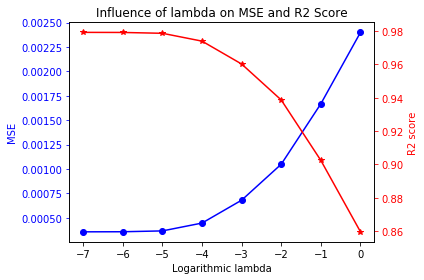

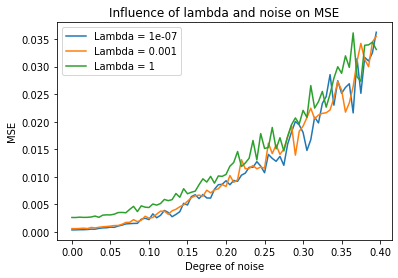

In [10]:
#from AnalysisFunctions import *
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
from sklearn.utils import resample
"""
Analysis of a Ridge Regression model of Franke's function, using set of 1000 random x and y points
"""
# Load random data, 1000 points
X = np.load('data.npy')
x = X[:, 0]
y = X[:, 1]

# Calculate Franke's function without noise
z = FrankeFunction(x, y)

# Study dependence on lambdas
lambdas = [10**-7, 10**-6, 10**-5, 10**-4, 10**-3, 10**-2, 10**-1, 1]
lambdas_log = [-7, -6, -5, -4, -3, -2, -1, 0]

text_file = open("../Results/ex4/Bootstrap_ridge.txt", "w")
text_file.write('Investigate lambdas \n')
Bs = []
for la in lambdas:
    Bs.append(RidgeRegression(x, y, z, l=la))

# Generate test data
x_test = np.random.rand(200)
y_test = np.random.rand(200)
z_test = FrankeFunction(x_test, y_test)

# Calculate MSE, R2scores
M_ = np.c_[x_test, y_test]
poly5 = PolynomialFeatures(5)
M = poly5.fit_transform(M_)

MSEs = []
R2s = []
for i in range(len(lambdas)):
    z_predict = M.dot(Bs[i])
    MSE = MeanSquaredError(z_test, z_predict)
    MSEs.append(MSE)
    R2_score = R2(z_test, z_predict)
    R2s.append(R2_score)
    text_file.write('--- Lambda value: {0} ---\n Mean Squared error: {1:.7f} \n R2 Score: {2:.7f}\n'.format(lambdas[i], MSE, R2_score))

#plot
fig, ax1 = plt.subplots()
ax1.plot(lambdas_log, MSEs, 'bo-')
ax1.set_xlabel('Logarithmic lambda')
ax1.set_ylabel('MSE', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.plot(lambdas_log, R2s, 'r*-')
ax2.set_ylabel('R2 score', color='r')
ax2.tick_params('y', colors='r')

plt.title('Influence of lambda on MSE and R2 Score')
fig.tight_layout()
plt.savefig('../Results/ex4/MSE_R2_lambda.png')

# consider how the strength of noise affects the lambda values
noise = np.arange(0, 0.4, 0.005)
lambdas = [10**-7, 10**-3, 1 ]
Bs = []

# Generate more data to test
x_test = np.random.rand(200)
y_test = np.random.rand(200)
M_ = np.c_[x_test, y_test]
poly5 = PolynomialFeatures(5)
M = poly5.fit_transform(M_)

for la in lambdas:
    B = []
    for n in noise:
        z = FrankeFunction(x, y, noise=n)
        B.append(RidgeRegression(x, y, z, l=la))
    Bs.append(B)

lines = []
plt.figure()
for i in range(len(lambdas)):
    text_file.write('--- lambda value:{}---'.format(lambdas[i]))
    line = []
    for j in range(len(noise)):
        z_test = FrankeFunction(x_test, y_test, noise=noise[j])
        z_predict = M.dot(Bs[i][j])
        MSE = MeanSquaredError(z_test, z_predict)
        line.append(MSE)
        R2_score = R2(z_test, z_predict)
        text_file.write(' Noise: {0} \n Mean Squared error: {1:.7f} \n R2 Score: {2:.7f}\n'.format(noise[j], MSE, R2_score))
    plt.plot(noise, line, label='Lambda = {0}'.format(lambdas[i]))

plt.legend()
plt.xlabel('Degree of noise')
plt.ylabel('MSE')
plt.title('Influence of lambda and noise on MSE')
plt.savefig('../Results/ex4/lambda_noise_MSE.png')

#confidence interval

# Generate test data
x_test1 = np.random.rand(1000)
y_test1 = np.random.rand(1000)
z_test1 = FrankeFunction(x_test1, y_test1)

# Calculate beta values and polynomial matrix
beta = RidgeRegression(x, y, z, degree=5, l=10**-4)
M_ = np.c_[x_test1, y_test1]
poly5 = PolynomialFeatures(5)
M = poly5.fit_transform(M_)

# Calculate beta confidence intervals
conf1, conf2 = betaCI_Ridge(z_test1, beta, M, l=10**-4)

for i in range(len(conf1)):
    text_file.write('Beta {0}: {1:5f} & [{2:5f}, {3:5f}]'.format(i, beta[i], conf1[i], conf2[i]))

# Use bootstrap algorithm to estimate MSE, R2, bias and variance
MSE_b, R2_b, bias_b, variance_b = bootstrap(x, y, z, method='Ridge', p_degree=5)
text_file.write('--- BOOTSTRAP for Ridge --- \n')
text_file.write('MSE: {} \n'.format(MSE_b))
text_file.write('R2: {} \n'.format(R2_b))
text_file.write('Bias: {} \n'.format(bias_b))
text_file.write('Variance: {} \n'.format(variance_b))
text_file.close()



In [2]:
"""
Functions to use in analysis of regression methods
"""
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
from matplotlib import cm

def FrankeFunction(x,y, noise = 0):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return (term1 + term2 + term3 + term4 + noise*np.random.randn(len(x)))


def R2(zReal, zPredicted):
    """
    :param zReal: actual z-values, size (n, 1)
    :param zPredicted: predicted z-values, size (n, 1)
    :return: R2-score
    """
    R2 = 1 - (np.sum((zReal - zPredicted)**2)/np.sum((zReal - np.mean(zReal))**2))
    return R2

def MeanSquaredError(zReal, zPredicted):
    """
    :param zReal: actual z-values, size (n, 1)
    :param zPredicted: predicted z-values, size (n, 1)
    :return: Mean squared error
    """
    MSE = np.sum((zReal - zPredicted)**2)/len(z)
    return MSE

def betaCI_OLS(zReal, beta_mean, X):
    """
    :param zReal: actual z-values, size (n, 1)
    :param beta_mean: mean of beta
    :param X: dataset
    Compute a 90% confidence interval for the beta coefficients
    """

    # Calculate variance squared in the error
    z_hat = X.dot(beta)
    N, P = np.shape(X)
    sigma2 = (np.sum(np.power((zReal-z_hat), 2)))/N

    # Calculate the variance squared of the beta coefficients
    var_beta = np.diag(sigma2*np.linalg.inv((X.T.dot(X))))

    # The square root of var_beta is the standard error. Confidence intervals are calculated as mean +/- Z*SE
    ci_minus = beta_mean - 1.645*var_beta
    ci_plus = beta_mean + 1.645*var_beta

    return ci_minus, ci_plus


def betaCI_Ridge(zReal, beta_mean, X, l):
    """
    :param zReal: actual z-values, size (n, 1)
    :param beta_mean: mean of beta
    :param X: dataset
    Compute a 90% confidence interval for the beta coefficients - Ridge
    """

    # Calculate variance squared in the error
    z_hat = X.dot(beta)
    N, P = np.shape(X)
    sigma_2 = (np.sum(np.power((zReal-z_hat), 2)))/N

    # Calculate the variance squared of the beta coefficients
    XTX= X.T.dot(X)
    R, R = np.shape(XTX)
    var_beta = np.diag(sigma_2*np.linalg.inv((XTX + l*np.identity(R))))

    # The square root of var_beta is the standard error. Confidence intervals are calculated as mean +/- Z*SE
    ci_minus = beta_mean - 1.645*var_beta
    ci_plus = beta_mean + 1.645*var_beta

    return ci_minus, ci_plus

def plotFrankes(x_, y_, z_):
    """
    Plot Franke's function
    """

    fig = plt.figure()
    ax = fig.gca(projection='3d')

    surf = ax.plot_surface(x_, y_, z_, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

    # Customize the z axis.
    ax.set_zlim(-0.10, 1.40)
    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))


    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z - Franke')

    # Add a color bar which maps values to colors.
    clb = fig.colorbar(surf, shrink=0.5, aspect=5)
    clb.ax.set_title('Level')

    plt.show()

#Ordinary Least Squared function
def ols(x, y, z, degree = 5):
    #x: vector of size(n, 1)
    #y: vector of size(n,1)
    #z: vector of size(n,1)
    xyb_ = np.c_[x, y]
    poly = PolynomialFeatures(degree)
    xyb = poly.fit_transform(xyb_)
    beta = np.linalg.inv(xyb.T.dot(xyb)).dot(xyb.T).dot(z)

    return beta

def RidgeRegression(x, y, z, degree=5, l=0.0001):
    """
    :param x: numpy vector of size (n, 1)
    :param y: numpy vector of size (n, 1)
    :param degree: degree of polynomial fit
    :param l: Ridge penalty coefficient
    :return: numpy array with the beta coefficients
    """
    # Calculate matrix with x, y - polynomials
    M_ = np.c_[x, y]
    poly = PolynomialFeatures(degree)
    M = poly.fit_transform(M_)

    # Calculate beta
    A = np.arange(1, degree + 2)
    rows = np.sum(A)
    beta = (np.linalg.inv(M.T.dot(M) + l * np.identity(rows))).dot(M.T).dot(z)

    return beta

def Lasso(x, y, z, degree=5, a=1e-06):

    X = np.c_[x, y]
    poly = PolynomialFeatures(degree=degree)
    X_ = poly.fit_transform(X)

    clf = linear_model.Lasso(alpha=a, max_iter=5000, fit_intercept=False)
    clf.fit(X_, z)
    beta = clf.coef_

    return beta

def bootstrap(x, y, z, p_degree, method, n_bootstrap=100):
    # Randomly shuffle data
    data_set = np.c_[x, y, z]
    np.random.shuffle(data_set)
    set_size = round(len(x)/5)

    # Extract test-set, never used in training. About 1/5 of total data
    x_test = data_set[0:set_size, 0]
    y_test = data_set[0:set_size, 1]
    z_test = data_set[0:set_size, 2]
    test_indices = np.linspace(0, set_size-1, set_size)

    # And define the training set as the rest of the data
    x_train = np.delete(data_set[:, 0], test_indices)
    y_train = np.delete(data_set[:, 1], test_indices)
    z_train = np.delete(data_set[:, 2], test_indices)

    Z_predict = []

    MSE = []
    R2s = []
    for i in range(n_bootstrap):
        x_, y_, z_ = resample(x_train, y_train, z_train)

        if method == 'Ridge':
            # Ridge regression, save beta values
            beta = RidgeRegression(x_, y_, z_, degree=p_degree)
        elif method == 'Lasso':
            beta = Lasso(x_, y_, z_, degree=p_degree)
        elif method == 'OLS':
            beta = ols(x_, y_, z_, degree=p_degree)
        else:
            print('ERROR: Cannot recognize method')
            return 0

        M_ = np.c_[x_test, y_test]
        poly = PolynomialFeatures(p_degree)
        M = poly.fit_transform(M_)
        z_hat = M.dot(beta)

        Z_predict.append(z_hat)

        # Calculate MSE
        MSE.append(np.mean((z_test - z_hat)**2))
        R2s.append(R2(z_test, z_hat))

    # Calculate MSE, Bias and Variance
    MSE_M = np.mean(MSE)
    R2_M = np.mean(R2s)
    bias = np.mean((z_test - np.mean(Z_predict, axis=0, keepdims=True))**2)
    variance = np.mean(np.var(Z_predict, axis=0, keepdims=True))
    return MSE_M, R2_M, bias, variance
